In [1]:
#import Numpy
import os
import numpy as np

# Import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

#Now, import the FITS module inside Astropy
from astropy.io import fits

import math
import time
import numpy.ma as ma

#import package to caclulate remaining loop time 
from time import sleep
from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
# Let's define te directory where you are with the "get current working directory" command...
work_dir = os.getcwd()
print("I am in dir %s" % work_dir)

#We can go up by using the path.dirname
main_dir =os.path.dirname(work_dir)
print("Main directory is %s" % main_dir)

#We can then define the data directory using the os.path.join command
data_dir = os.path.join(main_dir,"data/secondData")
print("data dir is %s" % data_dir)

#..and we can define some output directory with the results
results_dir = os.path.join(main_dir,"results")

#if the directory does not exist, you can create it...
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    print("Directory %s created !" % results_dir)

I am in dir /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r/code
Main directory is /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r
data dir is /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r/data/secondData


In [3]:
#define the input file
input_filename = os.path.join(data_dir,"PSRJ2021_3deg_100mev_gti_bary.fits")

#First, open the file and check the information in it
fits_info = fits.open(input_filename)
#fits_info1 = fits.open(input_filename1)

#...like the number of HDU, in this case 5
fits_info.info()

Filename: /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r/data/secondData/PSRJ2021_3deg_100mev_gti_bary.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  EVENTS        1 BinTableHDU    257   26232R x 23C   [E, E, E, E, E, E, E, E, E, D, J, J, I, 3I, 32X, 32X, I, D, E, E, E, E, E]   
  2  GTI           1 BinTableHDU     77   1753R x 2C   [D, D]   


In [4]:
#We will look at the EVENTS table (HDU=1)
table_header = fits_info[1].header
table_data = fits_info[1].data

table_data.columns

ColDefs(
    name = 'ENERGY'; format = 'E'; unit = 'MeV'
    name = 'RA'; format = 'E'; unit = 'deg'
    name = 'DEC'; format = 'E'; unit = 'deg'
    name = 'L'; format = 'E'; unit = 'deg'
    name = 'B'; format = 'E'; unit = 'deg'
    name = 'THETA'; format = 'E'; unit = 'deg'
    name = 'PHI'; format = 'E'; unit = 'deg'
    name = 'ZENITH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'EARTH_AZIMUTH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'EVENT_ID'; format = 'J'
    name = 'RUN_ID'; format = 'J'
    name = 'RECON_VERSION'; format = 'I'
    name = 'CALIB_VERSION'; format = '3I'
    name = 'EVENT_CLASS'; format = '32X'
    name = 'EVENT_TYPE'; format = '32X'
    name = 'CONVERSION_TYPE'; format = 'I'
    name = 'LIVETIME'; format = 'D'; unit = 's'
    name = 'DIFRSP0'; format = 'E'
    name = 'DIFRSP1'; format = 'E'
    name = 'DIFRSP2'; format = 'E'
    name = 'DIFRSP3'; format = 'E'
    name = 'DIFRSP4'; format = 'E'
)

In [5]:
#Now convert the data to a Astropy Table object
from astropy.table import Table

evt_data = Table(table_data)
print("**Data contains %d events, this is the number of photons" % len(evt_data))

Nph = len(evt_data)

#convert data time in array
data_time = np.asarray(evt_data['TIME'])

**Data contains 26232 events, this is the number of photons


In [6]:
#-------------------DEFINE FUNCTION AND PARAMETERS FOR SCAN---------------------

#define the epoch as the central time of time intervall (T=54730-54820 MJD)
t0 = (251424001 + 243648001) /2

#define T as the difference of time intervall in MET
T = (251424001 - 243648001)

#define the initial values of f0,f1 and the spacing 
f_0start = 9.63935
f_1start = -8.8892e-12
df_0 = 0.15/T   #or 1/T 
df_1 = 0.3/T**2    #or 2/T**2

#define the array of f0,f1 to use for the scan
stepf0 = 1000
stepf1 = 50

f_0 = np.arange(f_0start-(stepf0/2)*df_0,f_0start+(stepf0/2)*df_0, df_0)
f_1 = np.arange(f_1start-(stepf1/2)*df_1,f_1start+(stepf1/2)*df_1, df_1)

print('**The number of step for f0 is %.0f, instead for f1 is %.0f' %(len(f_0), len(f_1)))

#define the number of harmonics
n = 8

#define function to calculate pulse phases
def Phi(f0,f1, time):
    phi = f0 * (time - t0) + f1/2 * (time - t0)**2
    frac_phi, int_phi = np.modf(phi)   #take the fractional part
    frac_phi[frac_phi<0] = frac_phi[frac_phi<0] + 1   #if phase is negative report it in [0,1] intervall
    return frac_phi

#define function for Ztest 
cos = np.empty(n+1)
sin = np.empty(n+1)

def Z2n(frac_phi):
    Z=0
    for k in range(1,n+1):
        cos[k] = np.sum(np.cos(2 * np.pi * k * frac_phi))
        sin[k] = np.sum(np.sin(2 * np.pi * k * frac_phi))
        Z += cos[k]**2 + sin[k]**2
    Z2n = (2/Nph) * Z
    return Z2n

#define function for scan
def main():
    for m in tqdm(range(len(f_0))):
        for s in range(len(f_1)):
            phase = Phi(f_0[m],f_1[s], data_time)
            Timing = Z2n(phase)
            x[s][m]= Timing
            Timing_list.append(Timing)
            f0_list.append(f_0[m])
            f1_list.append(f_1[s])
    return Timing_list, x, f0_list, f1_list


**The number of step for f0 is 1001, instead for f1 is 50


In [7]:
#----------------------------------SCAN OF f0 AND f1----------------------------------
start = time.time()


Timing_list = [] #list of Z2n values
f0_list = []
f1_list = []

#define a matrix whose indexes are the step of f0 and f1 and whose values are the Z2n
#calculated for those values of f0 and f1 (rows f1, columns f0)
x = np.empty((len(f_1),len(f_0))) 

#start scanning
Timing_list, x, f0_list, f1_list = main()

#found the maximum of Z2n
Z2n_max = np.max(Timing_list)
index_max = Timing_list.index(Z2n_max)
row , column = np.where(x == Z2n_max)


print('Maximum in Z-test : %f' %Z2n_max)
print('(f0,f1) : (%f,%e)' % (f0_list[index_max],f1_list[index_max]))
print('f0 step = %.0f\nf1 step = %.0f' %(column[0],row[0]))
print(time.time()-start)
Z2n_max, f0_list[index_max], f1_list[index_max], column[0], row[0]

  0%|          | 0/1001 [00:00<?, ?it/s]

Maximum in Z-test : 1253.811970
(f0,f1) : (9.639345,-8.889200e-12)
f0 step = 237
f1 step = 25
1294.478035211563


(1253.8119695795526, 9.639344926697488, -8.889199999999993e-12, 237, 25)

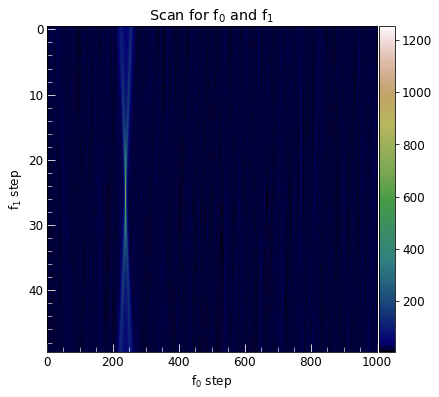

In [11]:
#plot the scan of f0,f1
plt.rc('font',size=12)
plt.figure(figsize=(7,6))
plt.title("Scan for f$_0$ and f$_1$")
plt.xlabel("f$_0$ step")
plt.ylabel("f$_1$ step")
plt.minorticks_on()

plt.imshow(x, cmap='gist_earth', aspect='auto')
cbar = plt.colorbar(pad = 0.005)

plt.tick_params('x', which='major', direction='in', length=8. , color = 'white')
plt.tick_params('y', which='major', direction='in', length=8. , color = 'white')
plt.tick_params('y', which='minor', direction='in', length=5., color = 'white')
plt.tick_params('x', which='minor', direction='in', length=5, color = 'white')


#save figure in results directory
out_name = os.path.join(results_dir,"scan.png")
plt.savefig(out_name, dpi = 300)
plt.show()

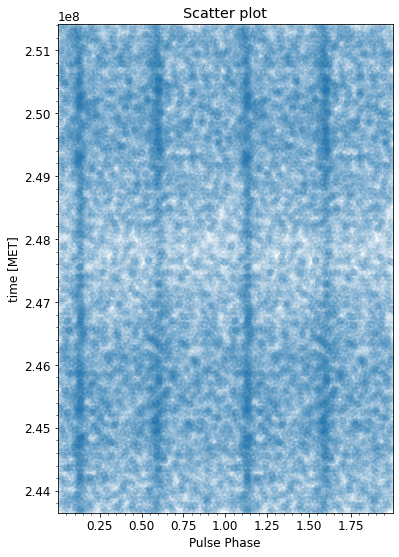

In [21]:
#-------------------------SCATTER PLOT-------------------------

#calculate the phases of photons using optimal parameters
phase_final = Phi(f0_list[index_max], f1_list[index_max], data_time)

phase_double = np.concatenate((phase_final, 1+phase_final))
time_double = np.concatenate((data_time, data_time))


plt.rc('font',size=12)
plt.figure(figsize=(6,9))
plt.title("Scatter plot")
plt.xlabel('Pulse Phase')
plt.ylabel("time [MET]")
plt.xlim(min(phase_double),max(phase_double))
plt.ylim(min(data_time),max(data_time))
plt.minorticks_on()

plt.scatter(phase_double, time_double, alpha=0.05,
            cmap='viridis')

#save figure in results directory
out_name = os.path.join(results_dir,"scatterplot.png")
plt.savefig(out_name, dpi = 300)
plt.show()

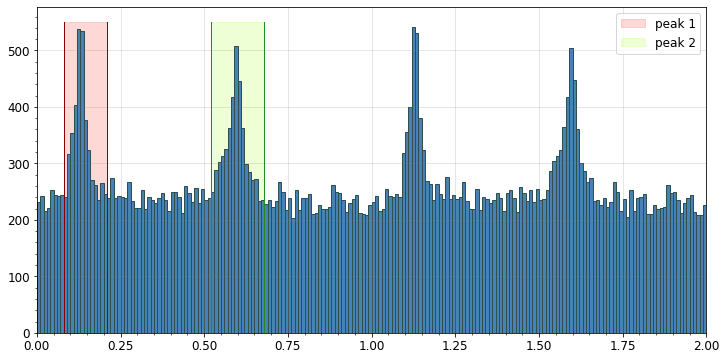

In [22]:
#-------------------FIRST PHASOGRAM-----------------------------

#duplicate the data of phases
phase_double = np.concatenate((phase_final, 1+phase_final)) 

#let's see histogram
plt.rc('font',size=12)
plt.figure(figsize=(12,6))
plt.grid(b=True, color='grey', linestyle='-', alpha=0.25)
plt.xlim(0,2)
plt.minorticks_on()

phase_count = plt.hist(phase_double, bins = 200,facecolor = 'steelblue', edgecolor='darkslategray')
plt.fill_between((0.08, 0.21), 0, 550, alpha=0.3, color = 'salmon', label='peak 1')
plt.plot([0.08,0.08],[0,550], linestyle='-', linewidth='1', color = 'darkred')
plt.plot([0.21,0.21],[0,550], linestyle='-', linewidth='1', color = 'darkred')
plt.fill_between((0.52, 0.68), 0, 550, alpha=0.2,color = 'greenyellow', label='peak 2')
plt.plot([0.52,0.52],[0,550], linestyle='-', linewidth='1', color = 'forestgreen')
plt.plot([0.68,0.68],[0,550], linestyle='-', linewidth='1', color = 'forestgreen')
plt.legend()

------------------------------------
| The mean value of bckg is 231.902778 
| The std value of bckg is 31.449766 
------------------------------------


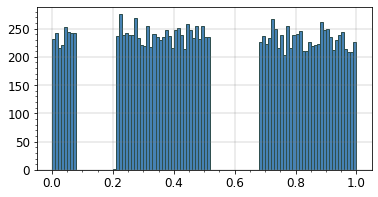

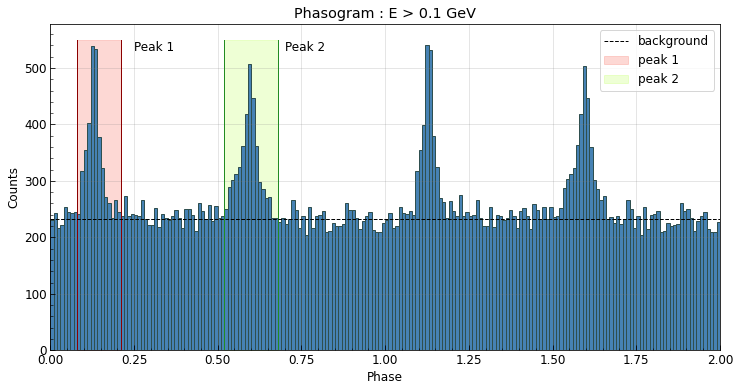

In [39]:
#---------------------------BACKGRAUND-----------------------------

#mask peaks intervall
mask_peak1 = ma.masked_inside(phase_final,0.08, 0.21)
mask_peak2 = ma.masked_inside(mask_peak1,0.52, 0.68)

#find where you masked
index_burst = ma.getmask(mask_peak2)

#array of phases without peaks
phase_noPeaks = phase_final[~index_burst]

#array of peaks
peaks = phase_final[index_burst]

#let's see it in an histogram
plt.rc('font',size=12)
plt.figure(figsize=(6,3))
plt.grid(color='gray',linewidth='0.3', b=True)
plt.minorticks_on()
count_bckg = plt.hist(phase_noPeaks, bins=100,facecolor = 'steelblue', edgecolor='darkslategray')

#calculate mean and std of bckg
bckg = count_bckg[0][count_bckg[0]!=0] #delete zeros in count of bckg
mean_bckg = np.mean(bckg)
std_bckg = np.std(bckg)

print("------------------------------------")
print("| The mean value of bckg is %f " % mean_bckg)
print("| The std value of bckg is %f " %std_bckg)
print("------------------------------------")

#let's see histogram
plt.rc('font',size=12)
plt.figure(figsize=(12,6))
plt.xlim(0,2)
plt.title('Phasogram : E > 0.1 GeV')
plt.xlabel('Phase')
plt.ylabel('Counts')

plt.grid(b=True, color='grey', linestyle='-', alpha=0.25)
plt.minorticks_on()
plt.tick_params('x', which='major', direction='in', length=5.)
plt.tick_params('y', which='major', direction='in', length=5.)
plt.tick_params('y', which='minor', direction='in', length=2.5, left=True)
plt.tick_params('x', which='minor', direction='in', length=2.5,bottom=True)


phase_count = plt.hist(phase_double, bins = 200,facecolor = 'steelblue', edgecolor='darkslategray')
plt.fill_between((0.08, 0.21), 0, 550, alpha=0.3, color = 'salmon', label='peak 1')
plt.plot([0.08,0.08],[0,550], linestyle='-', linewidth='1', color = 'darkred')
plt.plot([0.21,0.21],[0,550], linestyle='-', linewidth='1', color = 'darkred')
plt.fill_between((0.52, 0.68), 0, 550, alpha=0.2,color = 'greenyellow', label='peak 2')
plt.plot([0.52,0.52],[0,550], linestyle='-', linewidth='1', color = 'forestgreen')
plt.plot([0.68,0.68],[0,550], linestyle='-', linewidth='1', color = 'forestgreen')
plt.plot([0,2],[mean_bckg,mean_bckg], linestyle='--', linewidth='1', color = 'k', label='background')
plt.text(0.25, 530, 'Peak 1')
plt.text(0.70, 530, 'Peak 2')
plt.legend()


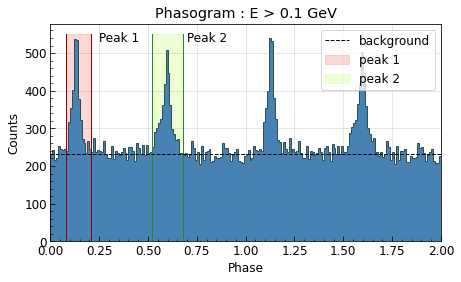

In [88]:
#let's see histogram : as before but using plt.ylim
plt.rc('font',size=12)
plt.figure(figsize=(7,4))
plt.xlim(0,2)
#plt.ylim(200,570)
plt.title('Phasogram : E > 0.1 GeV')
plt.xlabel('Phase')
plt.ylabel('Counts')

plt.grid(b=True, color='grey', linestyle='-', alpha=0.25)
plt.minorticks_on()
plt.tick_params('x', which='major', direction='in', length=5.)
plt.tick_params('y', which='major', direction='in', length=5.)
plt.tick_params('y', which='minor', direction='in', length=2.5, left=True)
plt.tick_params('x', which='minor', direction='in', length=2.5,bottom=True)


phase_count = plt.hist(phase_double, bins = 200,histtype='stepfilled',facecolor = 'steelblue', edgecolor='darkslategray')
plt.fill_between((0.08, 0.21), 0, 550, alpha=0.3, color = 'salmon', label='peak 1')
plt.plot([0.08,0.08],[0,550], linestyle='-', linewidth='1', color = 'darkred')
plt.plot([0.21,0.21],[0,550], linestyle='-', linewidth='1', color = 'darkred')
plt.fill_between((0.52, 0.68), 0, 550, alpha=0.2,color = 'greenyellow', label='peak 2')
plt.plot([0.52,0.52],[0,550], linestyle='-', linewidth='1', color = 'forestgreen')
plt.plot([0.68,0.68],[0,550], linestyle='-', linewidth='1', color = 'forestgreen')
plt.plot([0,2],[mean_bckg,mean_bckg], linestyle='--', linewidth='1', color = 'k', label='background')
plt.text(0.25, 530, 'Peak 1')
plt.text(0.70, 530, 'Peak 2')
plt.legend()


#save figure in results directory
out_name = os.path.join(results_dir,"phasogram1.png")
plt.savefig(out_name, dpi = 300)
plt.show()

<ErrorbarContainer object of 3 artists>

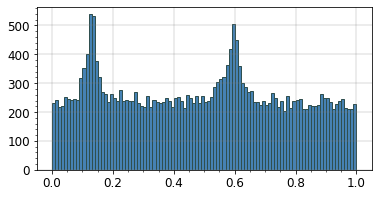

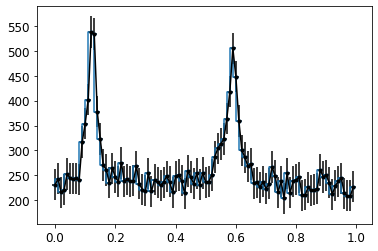

In [83]:
#-------------------------------PHASE INTERVAL: counts over 3 sigma-------------------------------
plt.rc('font',size=12)
plt.figure(figsize=(6,3))
plt.grid(color='gray',linewidth='0.3', b=True)
plt.minorticks_on()
hist = plt.hist(phase_final, bins=100,facecolor = 'steelblue', edgecolor='darkslategray')

#define counts and phase
count_hist = hist[0] #len 100
phase_hist = hist[1][0:100] #len 101, so select 0,100
plt.figure()

#define errors
dphi = np.ones(len(phase_hist))*0.01
dc = np.ones(len(count_hist))*std_bckg

#make a plot of phases vs counts
plt.step(phase_hist, count_hist, marker = '.')
plt.errorbar(phase_hist, count_hist,dc, dphi, linestyle = '-', color = 'black', marker = '.' )

Values of phases over 2 sigma are: 
  [0.0900487  0.10004784 0.11004697 0.12004611 0.13004525 0.14004438
 0.15004352 0.54000983 0.55000897 0.56000811 0.57000724 0.58000638
 0.59000551 0.60000465 0.61000379 0.62000292]


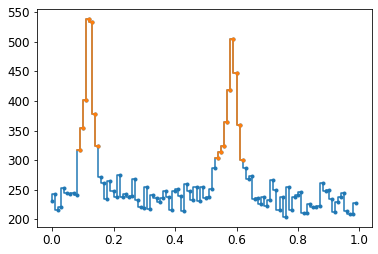

In [84]:
plt.step(phase_hist, count_hist, marker = '.')

#find where counts are over 3 sigma
count_over = ma.masked_where(count_hist < mean_bckg + 2 * std_bckg,count_hist)
index_under = ma.getmask(count_over)
phase_over = phase_hist[~index_under]

plt.step(phase_hist, count_over, marker = '.')

print("Values of phases over 2 sigma are: \n ",phase_over)

In [85]:
#-----------------------------DELTA PHI--------------------------------
phi1 = ( 0.0900487 + 0.15004352 ) / 2
phi2 = ( 0.54000983 + 0.62000292 ) / 2

Dphi = phi2 - phi1
print('Delta phi using separation between mean values of phase interval : %f \pm 0.02 ', Dphi)

Delta phi using separation between mean values of phase interval : %f \pm 0.02  0.459960265


Chi2_red :  0.3192671637655539
x0 : 0.124116 \pm 0.000733
a : 1053.614627 \pm 51.809731
gam : 0.030891 \pm 0.002744
cost : 229.968476 \pm 5.854715
-----------------------------------
Chi2_red :  0.3384461582487976
x0 : 0.589940 \pm 0.001158
a : 813.252193 \pm 47.000061
gam : 0.042004 \pm 0.004919
cost : 231.383060 \pm 8.950511
-----------------------------------


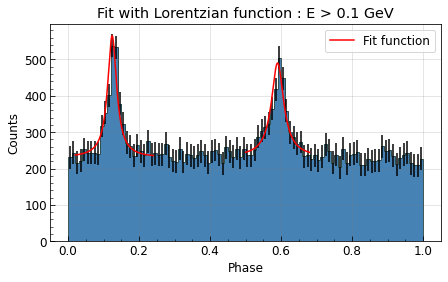

In [86]:
#--------------------------LORENTZIAN FITTING-----------------------------
import scipy
from scipy.optimize import curve_fit

#consider only the peak and mask the background
#Peak 1
phase_mask = ma.masked_outside(phase_hist, 0.02, 0.25)
mask_index = ma.getmask(phase_mask)
phase_ma = phase_hist[~mask_index]
count_ma = count_hist[~mask_index]
dc_ma = dc[~mask_index]
dphi_ma = dphi[~mask_index]

#Peak 2
phase_mask1 = ma.masked_outside(phase_hist, 0.5, 0.68)
mask_index1 = ma.getmask(phase_mask1)
phase_ma1 = phase_hist[~mask_index1]
count_ma1 = count_hist[~mask_index1]
dc_ma1 = dc[~mask_index1]
dphi_ma1 = dphi[~mask_index1]


#define Lorentzian function
#x0=PeakCentre, a=Amplitude, gam=full-width at half-maximum, cost=offset
def Lor(x, x0, a, gam, cost):
    return a/(np.pi) * (gam/2)**2 / ( (gam/2)**2 + (x - x0)**2) + cost

#define the initial values
init = (0.12, 1050, 0.02, 200)
init1 = (0.59, 800, 0.07, 200)


#-----------------------------------FIT ROUTINE PEAK 1 (considering only errors on y)
sigma=dc_ma
w=1/sigma**2

#call the minimization routine
pars,covm = curve_fit(Lor,phase_ma,count_ma,init,sigma)
err = np.sqrt (covm.diagonal())

# calculate the chisquare for the best-fit function
chi2 = ((w*(count_ma-Lor(phase_ma,*pars))**2)).sum()

# determine the ndof
ndof=len(phase_ma)-len(init)
chisq_r = chi2 / ndof

#print results on the console
print('Chi2_red : ', chisq_r)
print('x0 : %f \pm %f'% (pars[0], err[0]))
print('a : %f \pm %f' % (pars[1], err[1]))
print('gam : %f \pm %f' % (pars[2], err[2]))
print('cost : %f \pm %f' % (pars[3], err[3]))
print('-----------------------------------')

#------------------------------------FIT ROUTINE PEAK 2 (considering only errors on y)
sigma1=dc_ma1
w1=1/sigma1**2

#call the minimization routine
pars1,covm1 = curve_fit(Lor,phase_ma1,count_ma1,init1,sigma1)
err1 = np.sqrt (covm1.diagonal())

# calculate the chisquare for the best-fit function
chi21 = ((w1*(count_ma1-Lor(phase_ma1,*pars1))**2)).sum()

# determine the ndof
ndof1=len(phase_ma1)-len(init1)
chisq_r1 = chi21 / ndof1

#print results on the console
print('Chi2_red : ', chisq_r1)
print('x0 : %f \pm %f'% (pars1[0], err1[0]))
print('a : %f \pm %f' % (pars1[1], err1[1]))
print('gam : %f \pm %f' % (pars1[2], err1[2]))
print('cost : %f \pm %f' % (pars1[3], err1[3]))
print('-----------------------------------')


# prepare a dummy xx array (with 2000 linearly spaced points)
xx = np.linspace(min(phase_ma),max(phase_ma),2000)
xx1 = np.linspace(min(phase_ma1),max(phase_ma1),2000)


# plot the fitting curve computed with initial values
#plt.plot(xx,Lor(xx,*init), color='blue') #Peak 1 
#plt.plot(xx1,Lor(xx1,*init1), color='blue') #Peak 2

#-----------------------------------------PLOT-------------------------------------------------

plt.rc('font',size=12)
plt.figure(figsize=(7,4))
#plt.ylim(200,570)
plt.title('Fit with Lorentzian function : E > 0.1 GeV')
plt.xlabel('Phase')
plt.ylabel('Counts')

plt.grid(b=True, color='grey', linestyle='-', alpha=0.25)
plt.minorticks_on()
plt.tick_params('x', which='major', direction='in', length=5.)
plt.tick_params('y', which='major', direction='in', length=5.)
plt.tick_params('y', which='minor', direction='in', length=2.5, left=True)
plt.tick_params('x', which='minor', direction='in', length=2.5,bottom=True)

hist = plt.hist(phase_final, bins=100,histtype='stepfilled',facecolor = 'steelblue', edgecolor='darkslategray')
mid = 0.5*(hist[1][1:] + hist[1][:-1]) #calculate the middle of the bin, to put errorbar in the middle
plt.errorbar(mid, hist[0], yerr=dc, fmt='none',color = 'black')

#plt.step(phase_hist, count_hist,linestyle = '-', color = 'black', marker = '')
#plt.errorbar(phase_hist, count_hist,dc, dphi, linestyle = '', color = 'black', marker = '' )

#best fit curve of each peak
plt.plot(xx,Lor(xx,*pars), color='red', label = 'Fit function') 
plt.plot(xx1,Lor(xx1,*pars1), color='red') 

plt.legend()
#H = 2 * pars[1]/(pars[2]*np.pi)
#H

#save figure in results directory
out_name = os.path.join(results_dir,"fitLor.png")
plt.savefig(out_name, dpi = 300)
plt.show()

In [18]:
#-------------------DELTA PHI : using lorentzian fitting---------------------------
dx1 = pars[2]/2
dx2 = pars[2]/2

Dphi_l = pars1[0] - pars[0]
error = np.sqrt(dx1**2 + dx2**2)

print('Peaks are separeted by Dphi = %f \pm %f' %(Dphi_l, error))

Peaks are separeted by Dphi = 0.465859 \pm 0.021843


In [19]:
#-------------------------HEIGHT FRACTION OF PEAKS-------------------------------
H1 = max(Lor(xx,*pars)) - mean_bckg
H2 = max(Lor(xx1,*pars1)) - mean_bckg

H = H1/H2

print('H1 = %f \nH2 = %f \nH = %f' % (H1,H2,H))

H1 = 333.439160 
H2 = 260.248153 
H = 1.281235


In [20]:
#-------------------------HEIGHT FRACTION OF PEAKS: using counts array-------------------------------
(max(count_ma)- mean_bckg), (max(count_ma1)- mean_bckg) , (max(count_ma)- mean_bckg)/(max(count_ma1)- mean_bckg)

(306.09722222222223, 273.09722222222223, 1.1208360880842192)

In [43]:
#-----------------------------------CHARACTERISTIC AGE---------------------------
P = 1/f0_list[index_max] #seconds
Pdot = -f1_list[index_max]/(f0_list[index_max])**2
tau_c = ( P/(2*Pdot) ) / (60*60*24*365) #years

print('P = %f s \nPdot = %e s \ntau_c = %f yr' % (P, Pdot, tau_c))

P = 0.103741 s 
Pdot = 9.566821e-14 s 
tau_c = 17192.864515 yr


In [51]:
#--------------------------------MAGNETIC FIELD---------------------------------
B = 3.2e19 * np.sqrt(P * Pdot)

print('B = %e Gauss' % B)

B = 3.187939e+12 Gauss


In [48]:
#-------------------------------ROTATION LUMINOSITY---------------------------------
I = 1e45 #g/cm^2
Edot = 4*np.pi**2*I*Pdot/P**3

print('Edot = %e erg/s' % Edot)

Edot = 3.382750e+37 erg/s
